In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

df = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')



In [130]:
df.head(10)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8
5,Curbo,26Y1lX7ZOpw9Ql3gGAlqLK,Debauchery - Original mix,0.001150,0.810,124016,0.417,0.919,9,0.1060,-10.783,0,0.0793,120.025,4,0.837,8
6,Bingo Play,5eIyK73BrxHLnly4F9PWqg,Grandma - Original mix,0.000539,0.819,132742,0.720,0.863,4,0.0727,-8.895,0,0.1510,124.003,4,0.934,8
7,G Herbo,13Mf2ZBpfNkgWJowvM5hXh,Bon appétit,0.115000,0.885,181838,0.348,0.000,9,0.1070,-12.569,1,0.4510,142.111,4,0.180,10
8,34 Feet,7BQaRTHk44DkMhIVNcXy2D,Among - Original mix,0.000058,0.740,124016,0.472,0.847,8,0.0959,-9.008,1,0.0551,120.034,4,0.622,8
9,Chris Cooq,049RxG2laEl9U1PGYeIqLV,Hazard - Original mix,0.000081,0.813,132742,0.731,0.910,11,0.0727,-8.932,1,0.0697,124.031,4,0.944,7


In [73]:
df.track_name.astype(str)
df.dtypes

artist_name          object
track_id             object
track_name           object
acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
popularity            int64
dtype: object

In [74]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [75]:
def data(song1,song2,song3,song4):
    # Data will be mapped to point
    s1 = df[df['track_name'] == song1.lower()]
    s2 = df[df['track_name'] == song2.lower()]
    s3 = df[df['track_name'] == song3.lower()]
    s4 = df[df['track_name'] == song4.lower()]

    data = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness', 'loudness','speechiness','tempo'],
    (song1.lower(), [
            s1['acousticness'], s1['danceability'], s1['duration_ms'],s1['energy'], s1['instrumentalness'],
            s1['liveness'], s1['loudness'], s1['speechiness'], s1['tempo']]),
    (song2.lower(), [
            s2['acousticness'], s2['danceability'], s2['duration_ms'],s2['energy'], s2['instrumentalness'],
            s2['liveness'], s2['loudness'], s2['speechiness'], s2['tempo']]),
    (song3.lower(), [
            s3['acousticness'], s3['danceability'], s3['duration_ms'],s3['energy'], s3['instrumentalness'],
            s3['liveness'], s3['loudness'], s3['speechiness'], s3['tempo']]),
    (song4.lower(), [
            s4['acousticness'], s4['danceability'], s4['duration_ms'],s4['energy'], s4['instrumentalness'],
            s4['liveness'], s4['loudness'], s4['speechiness'], s4['tempo']])
        

    

In [116]:
song_name1 = 'Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj'
song_name2 = 'BAND DRUM (feat. A$AP Rocky)'

categories = ['acousticness','danceability','energy','instrumentalness','liveness', 'speechiness','tempo']
df2 = df[categories]


In [87]:
from sklearn import preprocessing

x = df2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled, columns=categories)

In [88]:
df2.head(10)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
0,0.005843,0.745984,0.339,0.000,0.081281,0.423395,0.815763
1,0.024498,0.849398,0.557,0.000,0.286286,0.473085,0.636079
2,0.025100,0.605422,0.723,0.000,0.082482,0.046998,0.459895
3,0.029518,0.803213,0.579,0.912,0.099499,0.072567,0.492045
4,0.000035,0.786145,0.792,0.878,0.033233,0.068427,0.480221
5,0.001155,0.813253,0.417,0.919,0.106106,0.082091,0.480133
6,0.000541,0.822289,0.720,0.863,0.072773,0.156315,0.496046
7,0.115462,0.888554,0.348,0.000,0.107107,0.466874,0.568483
8,0.000059,0.742972,0.472,0.847,0.095996,0.057039,0.480169
9,0.000081,0.816265,0.731,0.910,0.072773,0.072153,0.496158


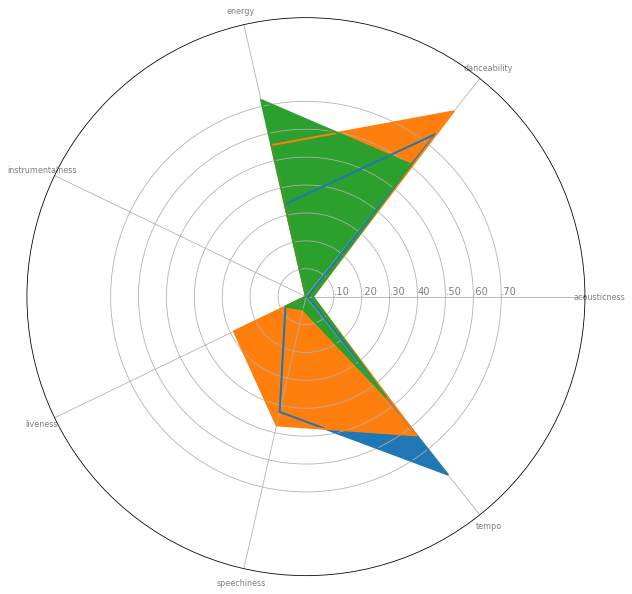

In [105]:
from math import pi
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20


N = 7

values = df2.loc[df['track_name']==song_name1]
values += values[:1]
#values = np.array(values)
song1 = df['track_name'][df['track_name']==song_name1]

values2=df2.loc[4]
values2 += values2[:1]
#values2 = np.array(values)
song2 = df['track_name'][4]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles = np.array(angles)

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([.10,.20,.30,.40,.50,.60,.70], [".10",".20",".30",'40','.50','.60','.70'], color="grey", size=10)
plt.ylim(0,1)

colors = ['b','o']
for x in range(3):
    values = df2.loc[x].values.flatten().tolist()
    values += values[:1]
    values = np.array(values)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles,values,alpha=1)


In [69]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly

data = [go.Scatterpolar(
            r = values,
            theta = categories,
            fill = 'toself',
            name = song1
        ),
        go.Scatterpolar(
            r = values2,
            theta = categories,
            fill = 'toself',
            name = song2)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 1]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.plot( fig, filename='spider-map' )

'file:///Users/joshsolis/repos/joshdsolis/data-science/spider-map.html'

In [70]:
import plotly.io as pio
pio.write_json(fig, 'figure.json', pretty=True)

In [81]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly

data = [go.Scatterpolar(
            r = values,
            theta = categories,
            fill = 'toself',
            name = song1
        )]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 1]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.plot( fig, filename='spider-map' )

'file:///Users/joshsolis/repos/joshdsolis/data-science/spider-map.html'

In [107]:
values.dtype

dtype('float64')

In [112]:
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
0,0.005843,0.745984,0.339,0.000,0.081281,0.423395,0.815763
1,0.024498,0.849398,0.557,0.000,0.286286,0.473085,0.636079
2,0.025100,0.605422,0.723,0.000,0.082482,0.046998,0.459895
3,0.029518,0.803213,0.579,0.912,0.099499,0.072567,0.492045
4,0.000035,0.786145,0.792,0.878,0.033233,0.068427,0.480221


In [124]:
values = df2[df['track_name'] == song_name1]
values2 = df2[df['track_name'] == song_name2]
data = pd.concat([values, values2])

In [127]:
data = pd.concat([values,values2])

In [128]:
data.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
0,0.00582,0.743,0.339,0.0,0.0812,0.409,203.927
1,0.02440,0.846,0.557,0.0,0.2860,0.457,159.009


In [129]:
data.to_json('spoopy.json')

In [155]:
import pandas as pd
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig


from sklearn.preprocessing import StandardScaler

# Separating out the features
x = df.loc[:, categories][:100].values
# Separating out the target
y = df.loc[:,['track_name']][:100].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [157]:
finalDf = pd.concat([principalDf, df[['track_name']][:100]], axis = 1)


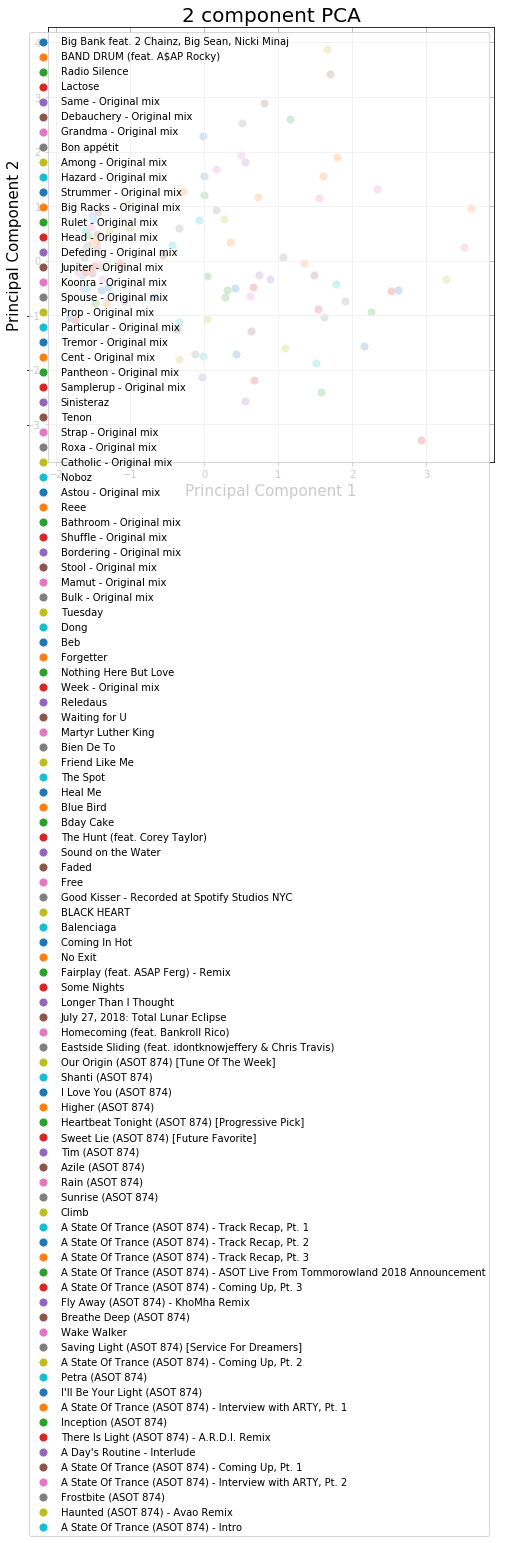

In [160]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(df.track_name[:100])
#colors = ['r', 'g', 'b']
for target in targets:
  indicesToKeep = finalDf['track_name'] == target
  ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
             finalDf.loc[indicesToKeep, 'principal component 2'],
             s = 50)
ax.legend(targets)
ax.grid()